In [1]:
!pip install pyspark pandas loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.7 MB/s eta 0:00:00


In [2]:
!rm -rf PruebaQuind
!git clone https://github.com/JulioIngAero/PruebaQuind.git

Cloning into 'PruebaQuind'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 1.23 MiB | 4.85 MiB/s, done.


In [35]:
# Configuración de librerías
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from loguru import logger


# Configuración de rutas
DATA_PATH = os.path.join(os.getcwd(), 'data')
EXCEL_FILE = os.path.join(DATA_PATH, '/content/PruebaQuind/Films_2 (4).xlsx')

In [36]:
# Clase de Extracción
class Extract:
    def __init__(self):
        self.excel_file = EXCEL_FILE

    def load_data(self):
        try:
            data = pd.read_excel(self.excel_file, sheet_name=None)
            logger.info(f"Datos cargados de {self.excel_file}: {list(data.keys())}")
            # Mostrar las primeras filas de cada hoja
            for sheet, df in data.items():
                logger.info(f"Contenido de la hoja {sheet}:")
                logger.info(df.head())
            return data
        except Exception as e:
            logger.error(f"Error al cargar los datos: {e}")
            return None

In [37]:
# Clase de Transformación
class Transform:
    def __init__(self):
        self.spark = SparkSession.builder.appName("ETL App").getOrCreate()

    def clean_data(self, df, numeric_columns):
        for col_name in numeric_columns:
            # Usar expresión regular para eliminar caracteres no numéricos y convertir al tipo adecuado
            if df.schema[col_name].dataType == 'int':
                df = df.withColumn(col_name, regexp_replace(col(col_name), '[^0-9]', '').cast('int'))
            else:
                df = df.withColumn(col_name, regexp_replace(col(col_name), '[^0-9.]', '').cast('float'))
        return df

    def transform_data(self, data):
        try:
            # Mostrar las claves del diccionario de datos
            logger.info(f"Claves de los datos cargados: {list(data.keys())}")

            # Convertir DataFrame de pandas a DataFrame de Spark
            spark_dfs = {}
            for sheet, df in data.items():
                logger.info(f"Procesando hoja: {sheet}")
                if df.empty:
                    logger.warning(f"La hoja {sheet} está vacía.")
                else:
                    spark_df = self.spark.createDataFrame(df)
                    # Renombrar columnas con espacios
                    for col_name in spark_df.columns:
                        spark_df = spark_df.withColumnRenamed(col_name, col_name.strip())

                    # Definir columnas numéricas para cada hoja relevante
                    if sheet == 'film':
                        numeric_columns = ['film_id', 'release_year', 'rental_rate', 'length', 'rental_duration', 'replacement_cost', 'num_voted_users']
                    elif sheet == 'customer':
                        numeric_columns = ['customer_id', 'store_id', 'address_id']
                        spark_df = spark_df.withColumnRenamed("active", "active")
                    elif sheet == 'rental':
                        numeric_columns = ['rental_id', 'inventory_id', 'customer_id', 'staff_id']
                    elif sheet == 'store':
                        numeric_columns = ['store_id', 'manager_staff_id', 'address_id']
                    else:
                        numeric_columns = [col_name for col_name in df.columns if pd.api.types.is_numeric_dtype(df[col_name])]

                    # Limpiar los datos
                    spark_df = self.clean_data(spark_df, numeric_columns)
                    spark_dfs[sheet] = spark_df

            # Aplicar transformaciones adicionales a la tabla 'customer'
            if 'customer' in spark_dfs:
                logger.info("La tabla 'customer' está presente. Aplicando transformaciones.")
                spark_dfs['customer'] = spark_dfs['customer'].filter(col("active") == 1)
            else:
                logger.error("La tabla 'customer' no está presente en los datos cargados.")

            return spark_dfs
        except Exception as e:
            logger.error(f"Error al transformar los datos: {e}")
            return None


In [31]:
# Clase de Transformación
class Transform:
    def __init__(self):
        self.spark = SparkSession.builder.appName("ETL App").getOrCreate()

    def clean_data(self, df, numeric_columns):
        for col_name in numeric_columns:
            df = df.withColumn(col_name, when(col(col_name).cast("float").isNotNull(), col(col_name).cast("float")).otherwise(None))
        return df

    def transform_data(self, data):
        try:
            # Mostrar las claves del diccionario de datos
            logger.info(f"Claves de los datos cargados: {list(data.keys())}")

            # Convertir DataFrame de pandas a DataFrame de Spark
            spark_dfs = {}
            for sheet, df in data.items():
                logger.info(f"Procesando hoja: {sheet}")
                if df.empty:
                    logger.warning(f"La hoja {sheet} está vacía.")
                else:
                    spark_df = self.spark.createDataFrame(df)
                    # Definir columnas numéricas para cada hoja relevante
                    if sheet == 'film':
                        numeric_columns = ['rental_rate', 'length']
                    elif sheet == 'customer':
                        numeric_columns = ['customer_id', 'store_id', 'address_id']
                        spark_df = spark_df.withColumnRenamed(" active", "active")
                    else:
                        numeric_columns = [col_name for col_name in df.columns if df[col_name].dtype in [int, float]]

                    spark_df = self.clean_data(spark_df, numeric_columns)
                    spark_dfs[sheet] = spark_df

            # Aplicar transformaciones adicionales a la tabla 'customer'
            if 'customer' in spark_dfs:
                logger.info("La tabla 'customer' está presente. Aplicando transformaciones.")
                spark_dfs['customer'] = spark_dfs['customer'].filter(col("active") == 1)
            else:
                logger.error("La tabla 'customer' no está presente en los datos cargados.")

            return spark_dfs
        except Exception as e:
            logger.error(f"Error al transformar los datos: {e}")
            return None

In [38]:
# Clase de Carga
class Load:
    def __init__(self, spark_dfs):
        self.spark_dfs = spark_dfs

    def save_data(self):
        try:
            for name, df in self.spark_dfs.items():
                logger.info(f"Guardando tabla {name} en formato Parquet.")
                df.write.mode("overwrite").parquet(f"/content/data/processed/{name}.parquet")
        except Exception as e:
            logger.error(f"Error al guardar los datos: {e}")

In [40]:
# Función principal
def main():
    logger.add("/content/etl.log", rotation="1 MB")

    try:
        # Extract
        logger.info("Starting data extraction")
        extractor = Extract()
        data = extractor.load_data()
        logger.info("Data extraction completed")

        if data:
            # Transform
            logger.info("Starting data transformation")
            transformer = Transform()
            transformed_data = transformer.transform_data(data)
            logger.info("Data transformation completed")

            if transformed_data:
                # Mostrar filas 9, 10 y 11 de la hoja 'film'
                logger.info("Filas 9, 10 y 11 de la hoja 'film':")
                print(transformed_data['film'].toPandas().iloc[8:11])

                # Load
                logger.info("Starting data loading")
                loader = Load(transformed_data)
                loader.save_data()
                logger.info("Data loading completed")

    except Exception as e:
        logger.error(f"Error in ETL process: {e}")



In [41]:
if __name__ == "__main__":
    main()

2024-12-02 04:01:57.255 | INFO     | __main__:main:7 - Starting data extraction
2024-12-02 04:02:01.697 | INFO     | __main__:load_data:9 - Datos cargados de /content/PruebaQuind/Films_2 (4).xlsx: ['MER', 'film', 'inventory', 'rental', 'customer', 'store']
2024-12-02 04:02:01.700 | INFO     | __main__:load_data:12 - Contenido de la hoja MER:
2024-12-02 04:02:01.705 | INFO     | __main__:load_data:13 - Empty DataFrame
Columns: []
Index: []
2024-12-02 04:02:01.709 | INFO     | __main__:load_data:12 - Contenido de la hoja film:
2024-12-02 04:02:01.714 | INFO     | __main__:load_data:13 -   film_id              title  \
0       1   ACADEMY DINOSAUR   
1       2     ACE GOLDFINGER   
2       3   ADAPTATION HOLES   
3       4   AFFAIR PREJUDICE   
4       5        AFRICAN EGG   

                                         description  release_year  \
0   A Epic Drama of a Feminist And a Mad Scientis...          2006   
1   A Astounding Epistle of a Database Administra...          2006   
2   A

    film_id              title  \
8       9.0      ALABAMA DEVIL   
9      10.0   ALADDIN CALENDAR   
10     11.0    ALAMO VIDEOTAPE   

                                          description  release_year  \
8    A Thoughtful Panorama of a Database Administr...        2006.0   
9    A Action-Packed Tale of a Man And a Lumberjac...        2006.0   
10   A Boring Epistle of a Butler And a Cat who mu...        2006.0   

    language_id original_language_id  rental_duration  rental_rate  length  \
8             1                 NULL              3.0         2.99   114.0   
9             1                 NULL              6.0         4.99    63.0   
10            1                 NULL              6.0         0.99   126.0   

    replacement_cost  num_voted_users  rating special_features  \
8              21.99          53100.0   PG-13         Trailers   
9              24.99          43800.0   NC-17         Trailers   
10             16.99          59850.0       G     Commentaries   



2024-12-02 04:02:06.055 | INFO     | __main__:save_data:9 - Guardando tabla inventory en formato Parquet.
2024-12-02 04:02:06.744 | INFO     | __main__:save_data:9 - Guardando tabla rental en formato Parquet.
2024-12-02 04:02:07.809 | INFO     | __main__:save_data:9 - Guardando tabla customer en formato Parquet.
2024-12-02 04:02:08.498 | INFO     | __main__:save_data:9 - Guardando tabla store en formato Parquet.
2024-12-02 04:02:09.091 | INFO     | __main__:main:28 - Data loading completed


## Preguntas

1. ¿Cuál es la tienda con el mayor volumen de clientes?

2. ¿Cuál es el promedio de duración de alquiler de las películas?

3. ¿Qué porcentaje de las películas están subtituladas en más de un idioma?

4. ¿Cuántos clientes activos y no activos hay en cada tienda?

5. ¿Cuál es la clasificación de películas más común en el catálogo?

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos procesados
films_df = pd.read_parquet('/content/data/processed/film.parquet')
customers_df = pd.read_parquet('/content/data/processed/customer.parquet')
rentals_df = pd.read_parquet('/content/data/processed/rental.parquet')
stores_df = pd.read_parquet('/content/data/processed/store.parquet')

La tienda con el mayor volumen de clientes es la tienda número: 1.0


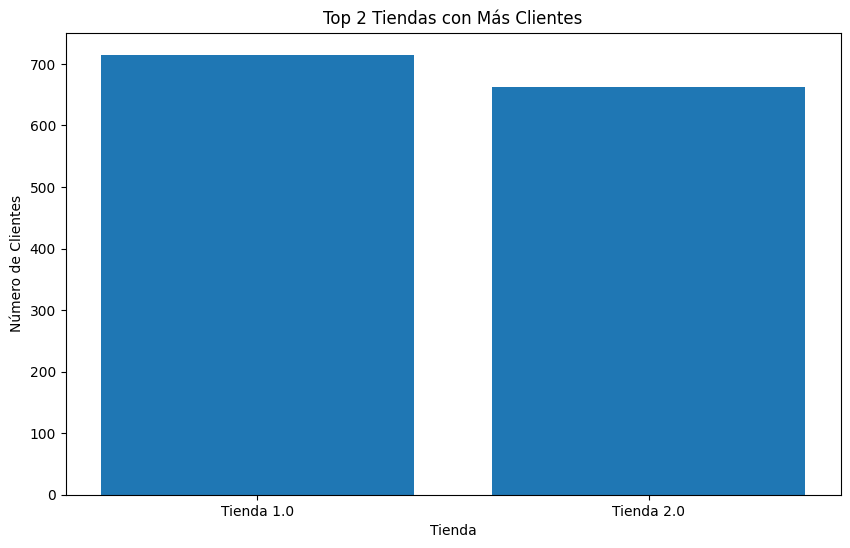

In [53]:
# Tienda con el mayor volumen de clientes
top_store_customers = customers_df['store_id'].value_counts().idxmax()
print(f"La tienda con el mayor volumen de clientes es la tienda número: {top_store_customers}")

# Gráfico de las 3 tiendas con más clientes
top_2_stores_customers = customers_df['store_id'].value_counts().head(3).index
top_2_customers_stores = customers_df[customers_df['store_id'].isin(top_2_stores_customers)].groupby('store_id').size()

plt.figure(figsize=(10, 6))
plt.bar(['Tienda ' + str(store) for store in top_2_stores_customers], top_2_customers_stores)
plt.title('Top 2 Tiendas con Más Clientes')
plt.xlabel('Tienda')
plt.ylabel('Número de Clientes')
plt.show()


El promedio de duración de alquiler de las películas es: 4.98 días


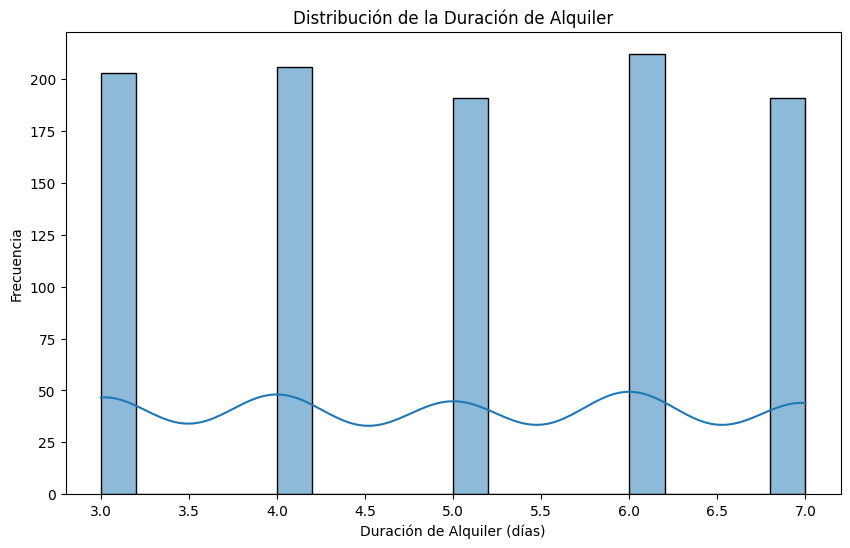

In [54]:
# Promedio de duración de alquiler
average_rental_duration = films_df['rental_duration'].mean()
print(f"El promedio de duración de alquiler de las películas es: {average_rental_duration:.2f} días")

# Gráfico de la distribución de la duración de alquiler
plt.figure(figsize=(10, 6))
sns.histplot(films_df['rental_duration'], bins=20, kde=True)
plt.title('Distribución de la Duración de Alquiler')
plt.xlabel('Duración de Alquiler (días)')
plt.ylabel('Frecuencia')
plt.show()

In [55]:
# Porcentaje de películas con subtítulos en más de un idioma
films_df['num_languages'] = films_df['special_features'].apply(lambda x: x.count('Subtitles') if pd.notnull(x) else 0)
films_with_multiple_subtitles = films_df[films_df['num_languages'] > 1].shape[0]
total_films = films_df.shape[0]
percentage_with_multiple_subtitles = (films_with_multiple_subtitles / total_films) * 100
print(f"El porcentaje de películas con subtítulos en más de un idioma es: {percentage_with_multiple_subtitles:.2f}%")

El porcentaje de películas con subtítulos en más de un idioma es: 0.00%


active      1
store_id     
1.0       715
2.0       662


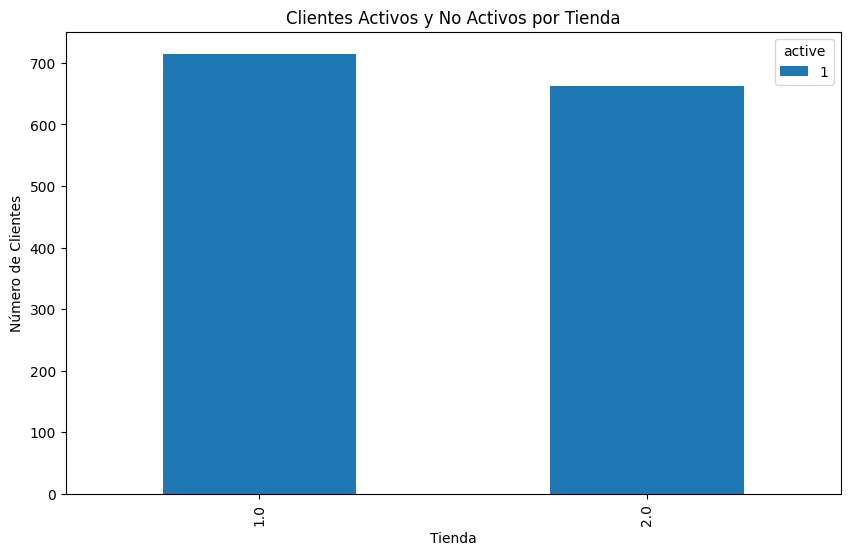

In [57]:
# Conteo de clientes activos y no activos por tienda
active_customers_by_store = customers_df.groupby(['store_id', 'active']).size().unstack().fillna(0)
print(active_customers_by_store)

# Gráfico de clientes activos y no activos por tienda
active_customers_by_store.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Clientes Activos y No Activos por Tienda')
plt.xlabel('Tienda')
plt.ylabel('Número de Clientes')
plt.show()

La clasificación de películas más común en el catálogo es:  PG-13


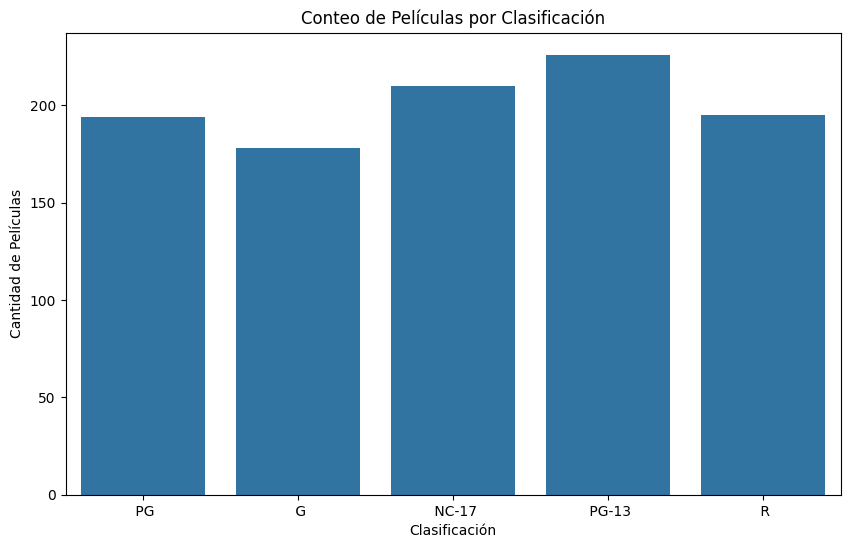

In [58]:
# Clasificación de películas más común
most_common_rating = films_df['rating'].mode().values[0]
print(f"La clasificación de películas más común en el catálogo es: {most_common_rating}")

# Gráfico de las clasificaciones de películas
plt.figure(figsize=(10, 6))
sns.countplot(data=films_df, x='rating')
plt.title('Conteo de Películas por Clasificación')
plt.xlabel('Clasificación')
plt.ylabel('Cantidad de Películas')
plt.show()